##### Combine datasets 'llm answers', galucinations, etc and visualize them

2024-11-05 13:26:42,188 - INFO - Max length across specified columns: 4096
2024-11-05 13:26:42,188 - INFO - ['NQ TRUE answers llama3.1', 'correct_answers_llama3.1', 'factual_inaccuracy_llama3.1']
2024-11-05 13:26:42,188 - INFO - Padding applied. Reduced embeddings shape: (20, 3)


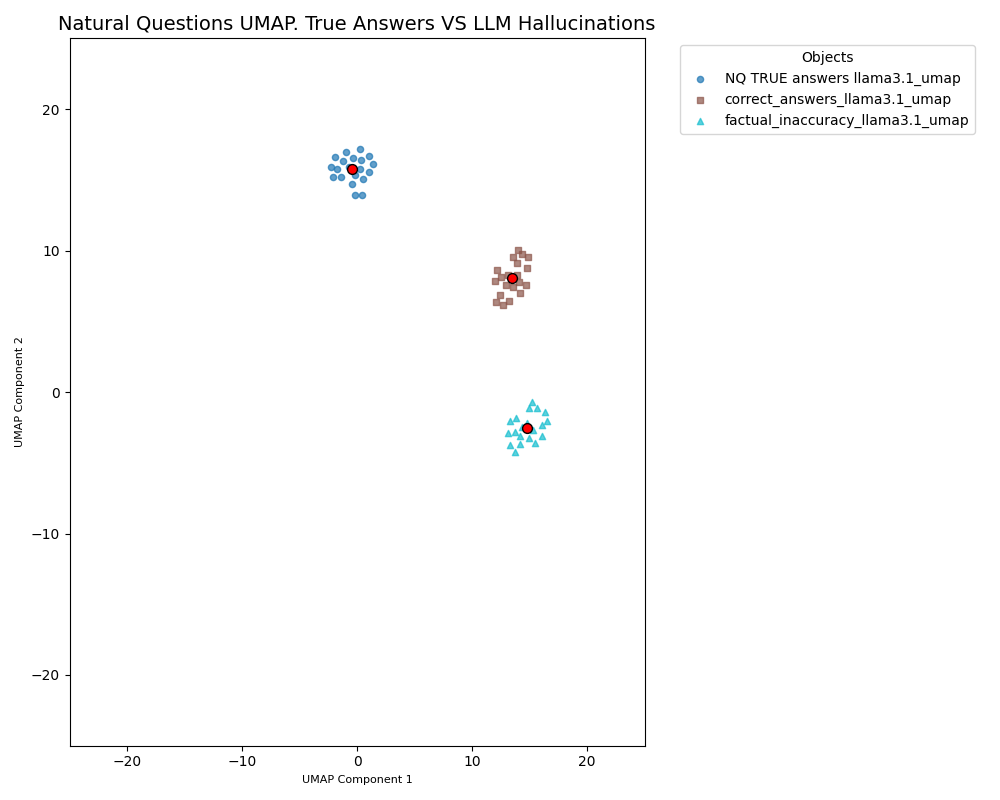

In [10]:
from PIL import Image
from src.services.similarity_service import find_centroids
from src.services.embedding_visualizer_service import EmbeddingVisualizer
import pandas as pd 
from IPython.display import display, Image as IPImage
import io    
import matplotlib.pyplot as plt

# Read LLM responses datasets 
true_answers = pd.read_csv('./data/llm_responses/NQ-llm-true-answers_llama3.1.csv')
correct_answers = pd.read_csv('./data/llm_responses/NQ-llm-correct_answers_llama3.1.csv')
factual_inaccuracy = pd.read_csv('./data/llm_responses/NQ-llm-factual_inaccuracy_llama3.1.csv')
#needle_in_haystack = pd.read_csv('./data/llm_responses/NQ-llm-needle_in_haystack_llama3.1.csv')

# Rename columns and concatenate datasets, keeping only the required columns
df_combined = pd.concat([
    true_answers.rename(columns={'true_answer_embedding_llama3.1': 'NQ TRUE answers llama3.1'})[['NQ TRUE answers llama3.1']],
    correct_answers.rename(columns={'embedding_llama3.1': 'correct_answers_llama3.1'})[['correct_answers_llama3.1']],
    factual_inaccuracy.rename(columns={'embedding_llama3.1': 'factual_inaccuracy_llama3.1'})[['factual_inaccuracy_llama3.1']]
    #needle_in_haystack.rename(columns={'embedding_llama3.1': 'needle_in_haystack_llama3.1'})[['needle_in_haystack_llama3.1']]
], axis=1)

# Display the combined DataFrame
# print(df_combined)

vis = EmbeddingVisualizer(df=df_combined)
vis.convert_columns_to_float_arrays()
vis.process_embeddings_padding()
df_umap = vis.apply_umap(n_components=2, rand_state=42)
centroids_df = find_centroids(df_umap)
img_buff = vis.plot_umap_2d(df=df_umap, 
                 centroids=centroids_df, 
                 title="Natural Questions UMAP. True Answers VS LLM Hallucinations")
display(Image.open(img_buff))

##### Generate images with different random seed

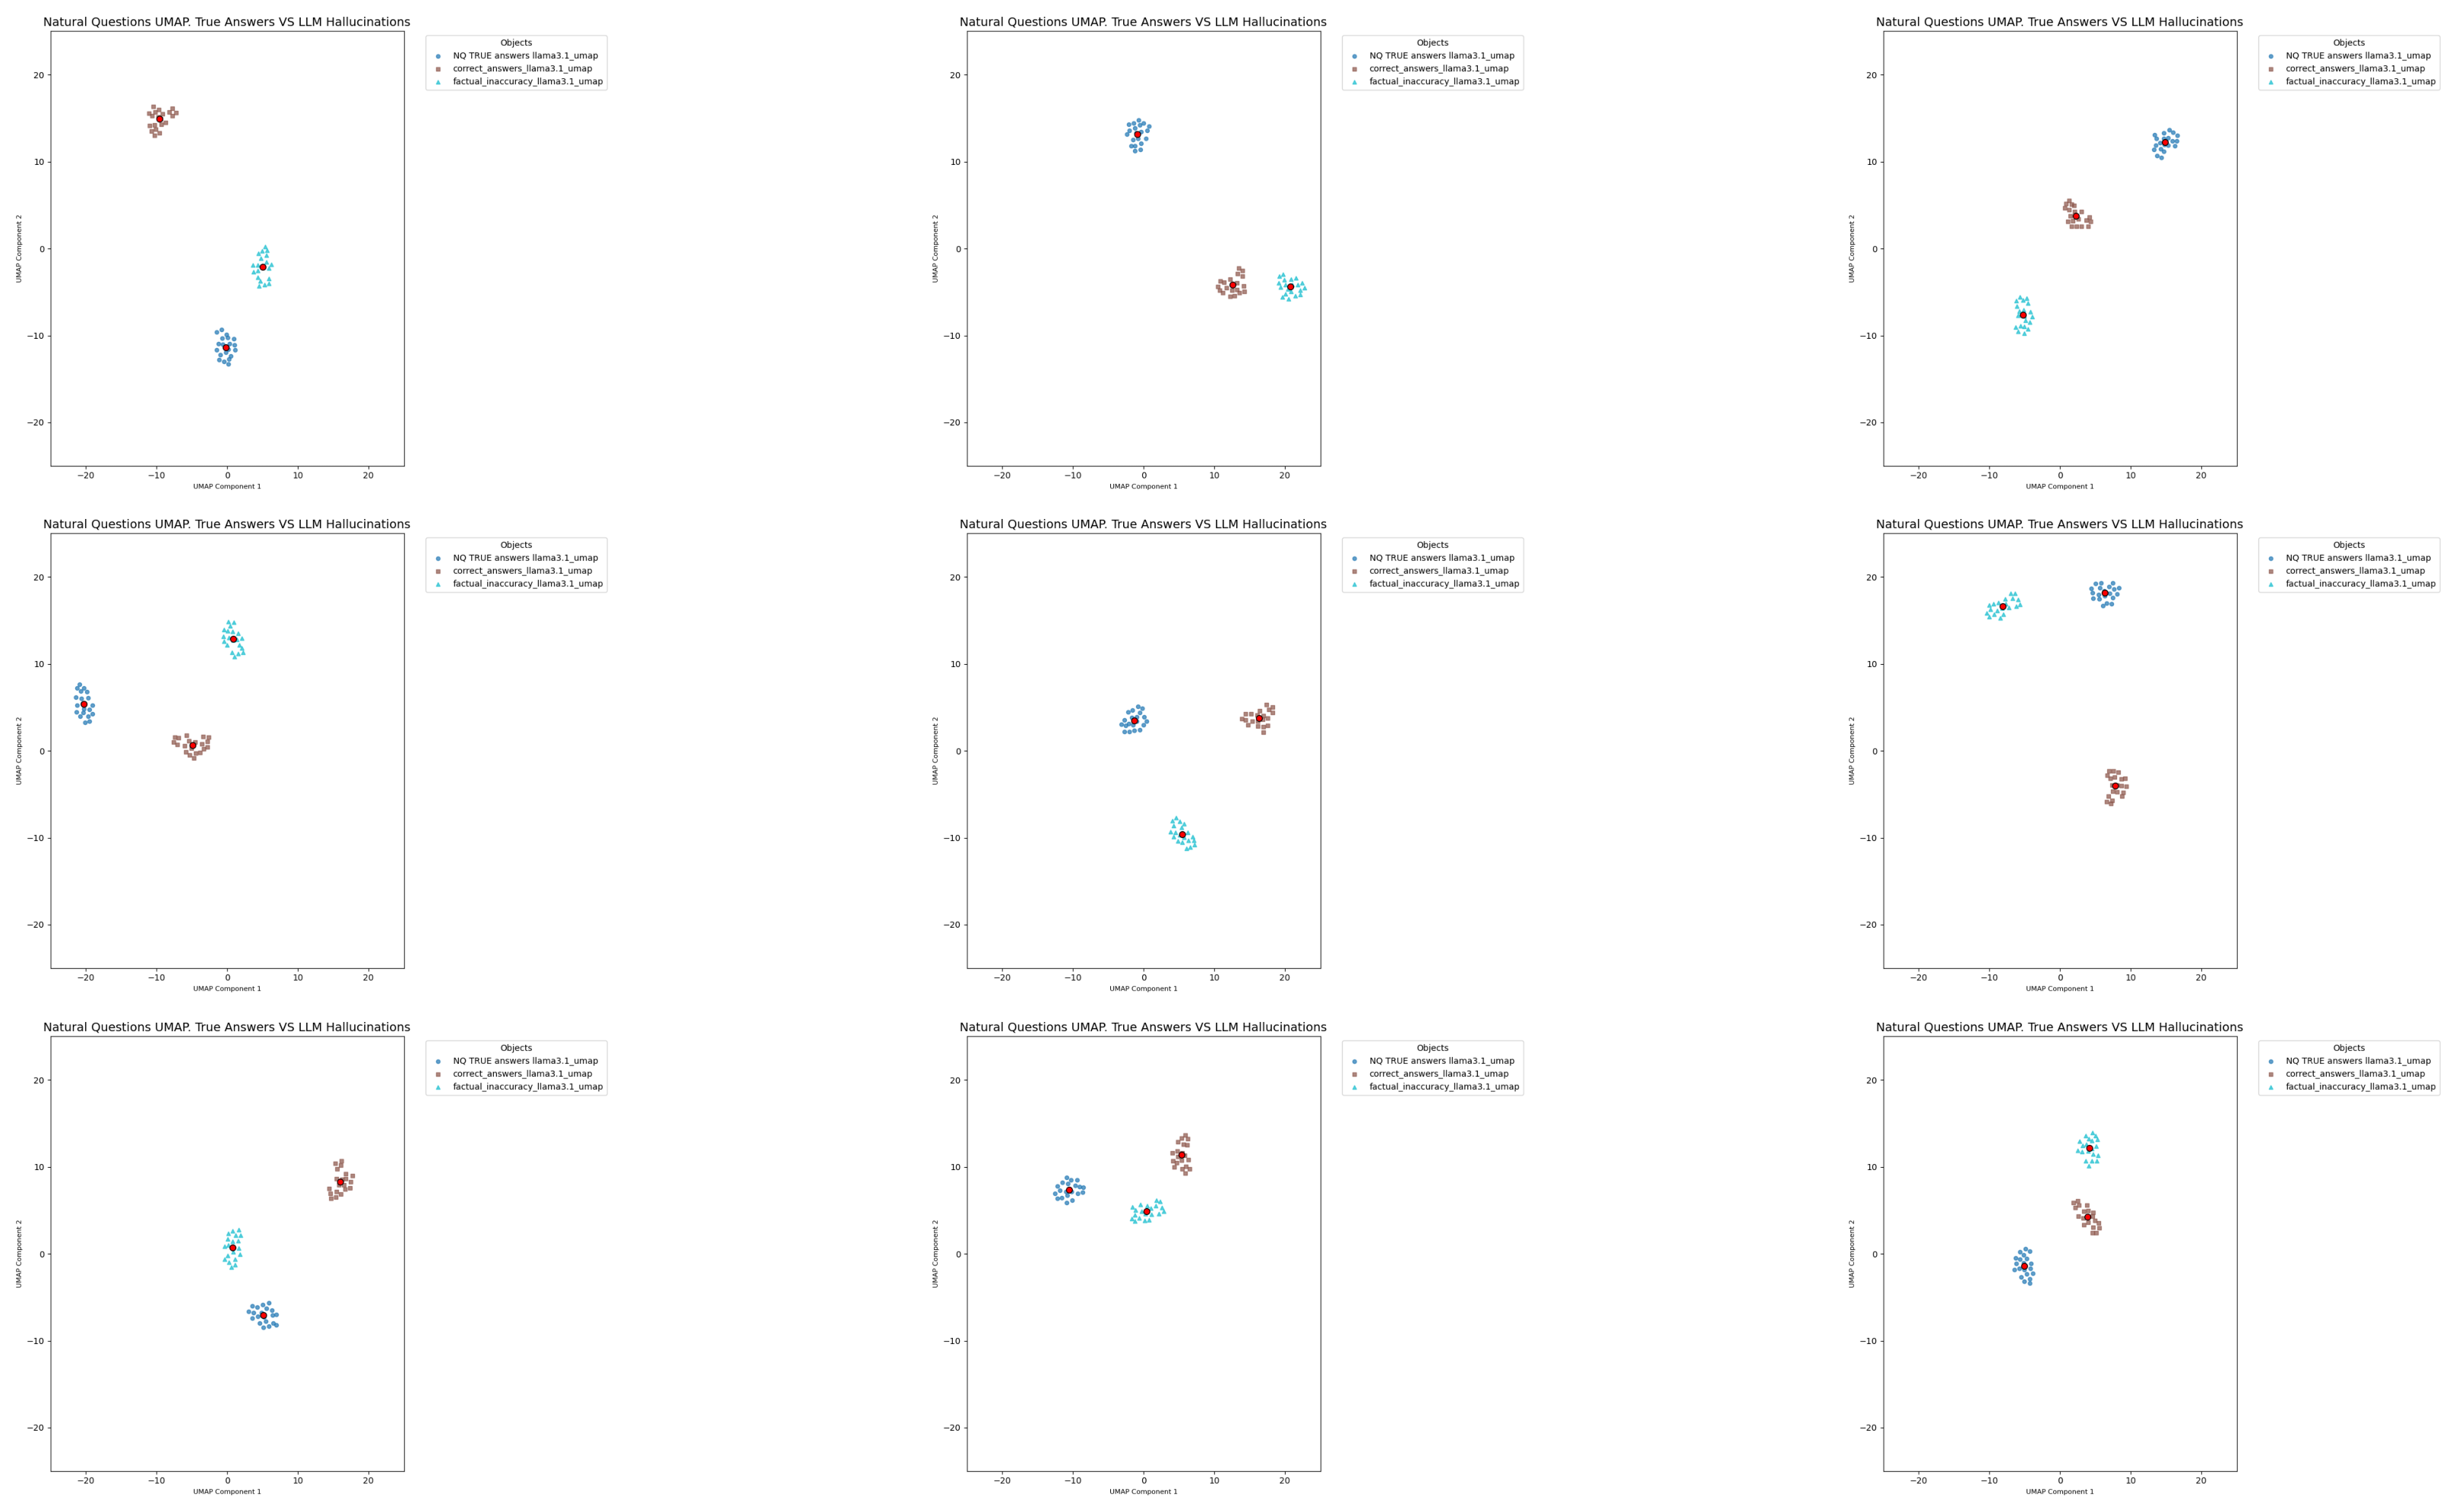

In [2]:
import numpy as np
from src.services.similarity_service import find_centroids

imgs = []

centroids_df = pd.DataFrame(columns=df_umap.columns)
for i in range(10):    
    df_umap = vis.apply_umap(n_components=2, rand_state=i)
    centroids_df = find_centroids(df_umap)
    img_buff = vis.plot_umap_2d(df=df_umap, 
                 centroids=centroids_df, 
                 title="Natural Questions UMAP. True Answers VS LLM Hallucinations")
    imgs.append(img_buff)

vis.plot_list_images_as_matrix(lines=3, columns=3, imgs=imgs)

#### Calculate distance between centroids of the classes with RANDOM seed. Calculate Euclidian distance between centroids

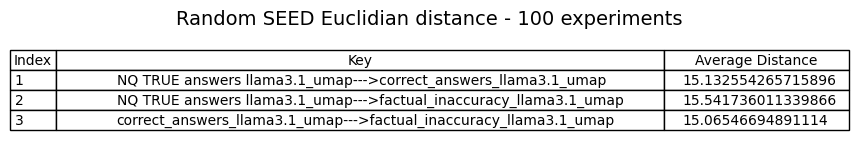

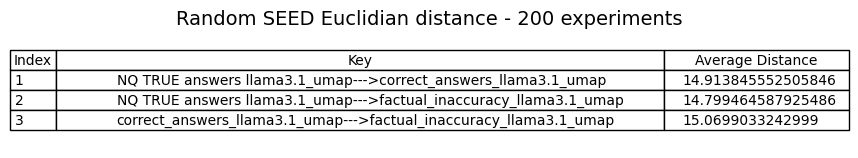

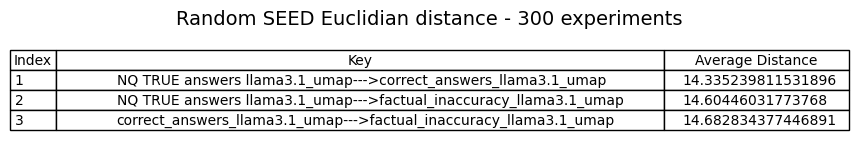

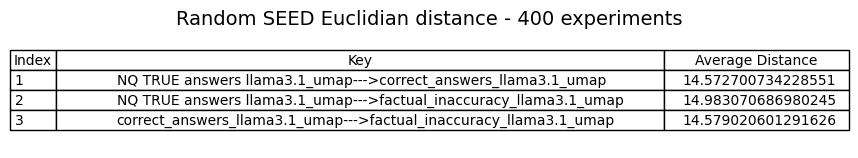

In [9]:
import numpy as np
from src.services.similarity_service import centroids_df_to_dict, euclidean_distance_dots, find_centroids
import random

NUMBER_OR_EXPERIMENTS = 500
PRINT_DATA_AFTER_N_EXPERIMENTS = 100

imgs = []
centroids_df = pd.DataFrame(columns=df_umap.columns)
euclidean_distances = {}

for i in range(NUMBER_OR_EXPERIMENTS):
    df_umap = vis.apply_umap(n_components=2, rand_state=random.randint(0, 10**6))
    centroids_df = find_centroids(df_umap)
    centroids_dict = centroids_df_to_dict(centroids_df)
    distance = euclidean_distance_dots(centroids_dict)

    for k, v in distance.items(): 
        tmp = euclidean_distances.get(k, [])
        tmp.append(v)
        euclidean_distances[k] = tmp
    if i != 0 and i % PRINT_DATA_AFTER_N_EXPERIMENTS == 0:
        average_distances = {k: sum(v) / len(v) for k, v in euclidean_distances.items()}
        vis.plot_average_similarities_result(f'Random SEED Euclidian distance - {i} experiments', average_distances)